In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add mavenn to the path
import sys
sys.path.insert(0, '../../../')# Load mavenn

import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn/examples/models/../../../mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 26,364
training + validation N: 504,373


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
5,training,2,108,1,-6.557858,AGKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,2,48,93,0.150206,AHKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
7,training,2,119,49,-2.052708,AIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,2,252,79,-2.450739,ALKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
9,training,2,110,116,-0.713724,AMKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='additive',                     
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [4]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

N = 504,373 observations set as training data.
Using 5.3% for validation.
Data shuffled.
Time to set data: 8.29 sec.


In [5]:
# Fit model to data
history = model.fit(learning_rate=.0005,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1524.4410 - val_loss: 784.3184 - I_var: 0.6126 - val_I_var: 0.6427
Epoch 2/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 548.8358 - val_loss: 99.3721 - I_var: 1.6301 - val_I_var: 1.6511
Epoch 3/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 45.5807 - val_loss: -60.5748 - I_var: 1.8655 - val_I_var: 1.8842
Epoch 4/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -78.0930 - val_loss: -125.6414 - I_var: 1.9747 - val_I_var: 1.9696
Epoch 5/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -138.9251 - val_loss: -164.3802 - I_var: 2.0317 - val_I_var: 2.0254
Epoch 6/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -177.7007 - val_loss: -196.6454 - I_var: 2.0743 - val_I_var: 2.0936
Epoch 7/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: -209.1222 - val_loss: -214.2435 - I_var: 2.1152 - val_I_var: 2.1034
Epoch 8/1000
478/478 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -231.4999 - val_loss: -238.0092 - I_

In [6]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.weights.h5


In [7]:
# Load model
model = mavenn.load('gb1_ge_additive')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.weights.h5


In [8]:
# Subsample indices for easy plotting and information estimation
N_test = len(test_df)
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

On test data:
I_var_test: 2.162 +- 0.037 bits
I_pred_test: 2.257 +- 0.024 bits


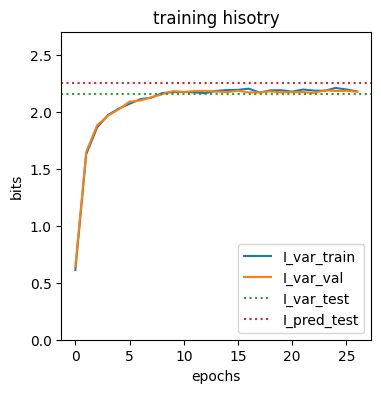

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x, y=y)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

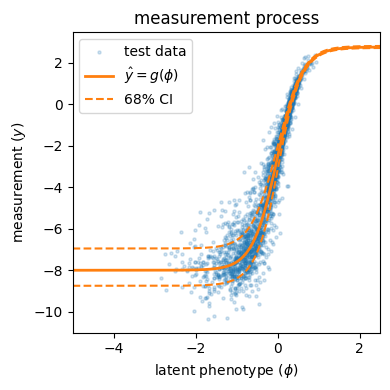

In [10]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label=r'$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel(r'latent phenotype ($\phi$)')
ax.set_ylabel(r'measurement ($y$)')
ax.set_title(r'measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

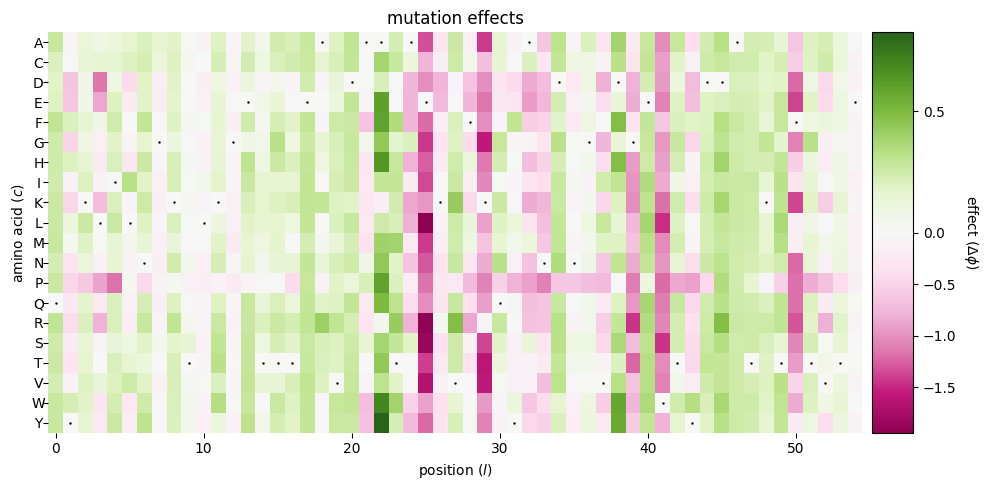

In [11]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
theta_dict = model.get_theta(gauge='user',
                             x_wt=gb1_seq)

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[10, 5])

# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
                        alphabet=theta_dict['alphabet'],
                        seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax)
ax.set_xlabel(r'position ($l$)')
ax.set_ylabel(r'amino acid ($c$)')
cb.set_label(r'effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')

# Fix up plot
fig.tight_layout()
plt.show()


In [12]:
# Test simulate_data
sim_df = model.simulate_dataset(template_df=test_df)
sim_df.head()

,set,phi,yhat,y,x
0,test,-0.307030,-5.086894,-4.868208,AKKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,test,0.072104,-1.918860,-3.068913,CCKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,test,-0.345134,-5.346017,-6.047636,DRKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,test,-0.189200,-4.191817,-1.232520,EQKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,test,-0.134243,-3.734006,-3.776834,ESKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
